<a href="https://colab.research.google.com/github/NganTran-0017/LING5412/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DEEP LEARNING MODELS - PART 2:**
**Description**
BERT is a pre-trained model for NLP tasks that was developped by Devlin from Google in 2018. Thanks to its ability in taking words from both directions (left and right) into context, 
BERT is capable of understand the contextual meaning of a sentence. As it was pretrained on Wikipedia corpus, BERT can achieve high performance after further finetuning on small datasets. Therefore, we choose BERT in this project with a hope that it can achieve high performance in detecting patronizing and condescending language.

In this notebook we load, process text data, and then partition it into training and testing sets. Next, we start processing text data with BERT pretrained tokenizer and embedding words in each training instance into numeric. Since this data is very imbalance, we add an upsampling option to see if the model can improve its performance. If upsampling option is checked above, we'll upsample the training set using SMOTE. 

Mask paddings are added to the processed training data and then we start finetuning the pretrained BERT model in 3 epochs and 32 batch size. Once the training is completed, we evaluate the model performance on the testing data, annd print the model performance. We also save BERT performance in a text file, whose name indicates whether the data was upsampled or not. This way, we can compare it against the rest of the models in the Visualization notebook. 

In [ ]:
#@title Specifying Upsampling Option
UPSAMPLE = False #@param {type:"boolean"}


In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

In [ ]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

In [ ]:
import tarfile
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree             # tree.DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #clf = svm.SVC(decision_function_shape='ovo')
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score

# **Loading data**

Connects google drive to this notebook to get the dataset, and then unzip it. Then, we load the specified columns (docID, keyword, country, paragraph and label) into the df.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip" -d "/content/drive/MyDrive/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip, /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.zip or /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.ZIP.


In [ ]:
# Opening the file from MyDrive
file = open(r'/content/drive/MyDrive/dontpatronizeme_v1.3/dontpatronizeme_pcl.tsv')
reader = csv.reader(file, delimiter="\t")
data = []
for row in reader:
  data.append(row)

df = pd.DataFrame(data[5:],  columns = ['docID', 'keyword', 'country', 'paragraph', 'label' ] )
df

,docID,keyword,country,paragraph,label
0,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,0
1,@@25567226,in-need,hk,A second T-Home project is being launched in t...,0
2,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,4
3,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,0
4,@@40039380,women,ng,Haruna stressed the need for specific approach...,0
...,...,...,...,...,...
10053,@@16413808,immigrant,my,"To me , I am always mindful that we are dealin...",4
10054,@@8676630,vulnerable,jm,Other themes included promoting the inclusion ...,0
10055,@@7688552,immigrant,gb,It came as the CDU was also humiliated by the ...,0
10056,@@4916290,hopeless,in,"Those were only days of helplessness , she say...",0


# **Exploring data**

Get the length of each data instance and plot its histogram.

In [ ]:
# Length of text
def length (txt):
  length = len(txt.split())
  return length

txt_length = df['paragraph'].apply(lambda x: length(x))
txt_length.sort_values(ascending = False)

3534    1519
6266    1095
8519    1040
4613     772
8819     729
        ... 
1930       4
1385       3
7375       3
5112       3
5742       0
Name: paragraph, Length: 10058, dtype: int64

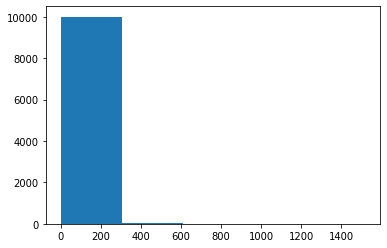

In [ ]:
# Plot the histogram of sentence length
plt.hist(txt_length, 5)
plt.show()

In [ ]:
# Observing labels
df['label'].value_counts()

0    8206
1     906
3     435
4     369
2     142
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].astype(str)
df['label']

0        0
1        0
2        4
3        0
4        0
        ..
10053    4
10054    0
10055    0
10056    0
10057    0
Name: label, Length: 10058, dtype: object

In [ ]:
#checking for missing values
print('Is null: \n', df.isnull().sum() )

Is null: 
 docID        0
keyword      0
country      0
paragraph    0
label        0
dtype: int64


There are 5 labels in this dataset. The label number represents the degree of patronizing and condescending language (PCL).  Label 0 are sentences that do not contain patronizing nor condescending language, where as Label 4 are sentences with highly PCL. Based on the value counts below, the majority of data is negative with a label 0, whereas only 946 records are positive. Positive data contain labels from 1 to 4.

In this project, we choose task 1 that is a binary classification of PCL. Therefore, we convert the labels into 0 and 1, where 0 means negative and 1 means positive. The negative data contain label 0 originally, and the positive data contain labels 1 to 4.

0    9112
1     946
Name: label, dtype: int64


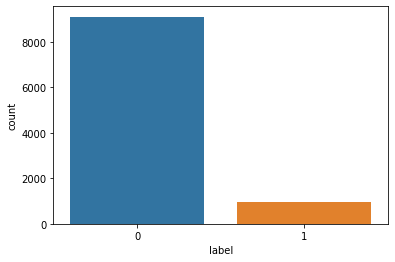

In [ ]:
# Turning labels to binary

label_dic = {'0':0,
             '1':0,
             '2':1,
             '3':1,
             '4':1}
df['label'] = df['label'].map(label_dic)
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# **Data Partition**

Once the data is thoroughly explored, we proceed to partition the shuffled data into training and testing sets with a ratio of 80-20. 

In [ ]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['paragraph']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (8046,) (8046,)
Shapes of X_test, y_test:  (2012,) (2012,)
0    7289
1     757
Name: label, dtype: int64


# **Create helper functions for printing and recording performance measures**

This part creates 2 helper function, where printing_eval_scores is responsible for printing out the model performance and get_roc_curve is responsible for extracting different metrics such as false positive rate (FPR), recall, macro-f1 scores and auc score. These 2 functions take the ground truth labels and predicted labels as inputs.

Since the data is very imbalanced, we decide to use macro-F1 score as a standard metric to compare among the candidate models. Macro-F1 score takes both major class and minor class into account regardless of their sizes. Therefore, using this metric will give us a more precise baseline to compare among the models. 

In [ ]:
# Printing model performance 
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred, average = 'macro', zero_division=1)))
  print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('F1 score: {}'.format(f1_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('\nConfusion Matrix:\n', confusion_matrix(y_true, y_pred))
  print('\n', classification_report(y_true, y_pred))

# Get the measurements of ROC curve for each model
def get_roc_cuve (y_true, y_pred):
  # Get arrays of FPR and recall using roc_curve
  FPR, recall, threshold = sklearn.metrics.roc_curve(y_true, y_pred)

  # Get testing accuracy:
  acc = accuracy_score( y_test,y_pred)

  # Get testing macro-f1:
  f1 = f1_score(y_test, y_pred,  average = 'macro', zero_division=1)

  # Get auc score
  auc = sklearn.metrics.auc(FPR, recall)
  roc = {'fpr': FPR, 'tpr': recall, 'auc': auc, 'accuracy': acc, 'macro-F1': f1}
  return roc

## **BERT**

In [ ]:
# Required packages for BERT is moved to the top, in case restart is required

**Prepare training and testing data for BERT**

In [ ]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(X_train[302])

['she',
 'learns',
 'to',
 'read',
 'with',
 'encouragement',
 'from',
 'her',
 'new',
 'family',
 'and',
 'max',
 ',',
 'a',
 'jewish',
 'refugee',
 'who',
 'they',
 'are',
 'hiding',
 'under',
 'the',
 'stairs',
 '.']

**Get maximum length of a sentence**

 If it's greater than 512, MAX_LEN is set to be 225. We tried to set it with 512, but we run out of GPU memory, so we decide to set it as 225.

In [ ]:
# get max len in tokenized train text to set the tokens length in the next step
MAX_LEN = max(map(len, X_train))  # can do len(max(X_train, key=len)) also
print('MAX LEN of trainning sentence is:', MAX_LEN, '\nMAX LEN > 512 is ', MAX_LEN>512)

# Update MAX LEN if it's > 512, set it to be 225 
## 512 is is the maximum seq len of BERT_BASE. But we cannot allow the seq len to be 512 since we'll run out of GPU memory --> Use max len of 225
MAX_LEN = 225 if MAX_LEN > 512 else MAX_LEN

# Convert to tokens using tokenizer
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[: MAX_LEN] + ['[SEP]'], X_train.to_list()))
test_tokens  = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[: MAX_LEN] + ['[SEP]'], X_test.to_list()))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Testing Sequences:', len(test_tokens) )

MAX LEN of trainning sentence is: 8779 
MAX LEN > 512 is  True
Number of Training Sequences: 8046 
Number of Testing Sequences: 2012


In [ ]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen= MAX_LEN, truncating="post", padding="post", dtype="int")
test_tokens_ids  = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)),  maxlen= MAX_LEN, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((8046, 225), (2012, 225))

In [ ]:
train_tokens_ids

array([[  101,  2016, 10229, ...,     0,     0,     0],
       [  101,  2045,  1005, ...,     0,     0,     0],
       [  101,  1996,  6505, ...,     0,     0,     0],
       ...,
       [  101,  2247,  2007, ...,     0,     0,     0],
       [  101,  5564,  1010, ...,     0,     0,     0],
       [  101,  1996,  2204, ...,     0,     0,     0]])

Upsampling option is available at the top of this notebook. If var UPSAMPLE is checked, the data will be upsampled using SMOTE.

In [ ]:
# Upsampling option
if UPSAMPLE:
  # Upsmapled training data for BERT
  oversampler = SMOTE(random_state=42)
  train_tokens_ids, train_labels = oversampler.fit_resample(train_tokens_ids, y_train)
else:
  train_labels = y_train

train_tokens_ids.shape, train_labels.shape

((8046, 225), (8046,))

In [ ]:
# Mask the paddings with 0 and words with 1
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [ ]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Initiate BERT Classifier using cuda
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

In [ ]:
EPOCHS = 3
BATCH_SZ = 32

# Train BERT NLP
bert_clf.train_m(train_tokens_ids, train_labels.to_numpy(),train_masks, EPOCHS, BATCH_SZ)

Epoch:  3
251/251.4375 loss: 0.09409347140795685 


In [ ]:
train_tokens_ids.shape

(8046, 225)

**Evaluate on Testing Set**

In [ ]:
## Converting test token ids, test labels and test masks to a tensor and the create a tensor dataset out of them.
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1)).float()

# Convert to tensor for maks
test_masks_tensor = torch.tensor(test_masks)


# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Define test data loader
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [ ]:
bert_clf.eval()     # Define eval
bert_predicted = [] # To Store predicted result
all_logits = []     # Predicted probabilities that is between 0 to 1 is stored here

with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        # Load the batch on gpu memory
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # Calculate ouput of bert
        logits = bert_clf(token_ids, masks)

        # Get the numpy logits
        numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
        
        # Using the threshold find binary 
        bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
        all_logits += list(numpy_logits[:, 0])

In [ ]:
rocs = {}
# Get ROC curve measurements
rocs['BERT'] = get_roc_cuve(y_test, bert_predicted)

# Prin performance
print('----------------------------BERT performance---------------------------')
printing_eval_scores(y_test, bert_predicted)

----------------------------BERT performance---------------------------
accuracy score: 0.9160039761431411
precision score: 0.9170063347360744
recall score: 0.9160039761431411
F1 score: 0.7561654582313556

Confusion Matrix:
 [[1736   87]
 [  82  107]]

               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1823
           1       0.55      0.57      0.56       189

    accuracy                           0.92      2012
   macro avg       0.75      0.76      0.76      2012
weighted avg       0.92      0.92      0.92      2012



In [ ]:
# Export performance to a txt file

# Set file name according to Upsampling option
if UPSAMPLE == 1: name = 'BERT_SMOTE'
else: name = 'BERT'

txtfile = open( name + '.txt','w')
txtfile.write(name + '=' +  str(rocs['BERT'])+'\n')

txtfile.close()

#**Visualize all models with ROC curves**

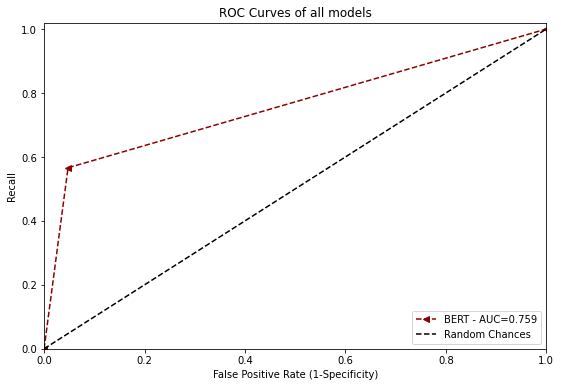

In [ ]:
def graph_multi_ROC (rocs):
  # Set color for each model
  colors = {'LGBM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'XGB': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'LGBM':'1--','LR': 'v--', 'SVM': '^--', 'XGB': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  for model in rocs:
    plt.plot( rocs[model]['fpr'], rocs[model]['tpr'], markers[model], color=colors[model], label= model+' - AUC=' + str(rocs[model]['auc'].round(3)) )
  
  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'ROC Curves of all models')
  plt.show()

graph_multi_ROC(rocs)